* In the name of God
* HW4 
* Amir Mohammad Yaghoobianzadeh

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import time, random, math, string
import os
from tqdm.notebook import tqdm

from google.colab import drive
from google.colab import drive
drive.mount('/content/gdrive')


%cd gdrive/MyDrive/Deep_learning/HW4

Mounted at /content/gdrive
/content/gdrive/MyDrive/Deep_learning/HW4


In [ ]:
# !git clone https://github.com/amnghd/Persian_poems_corpus
# !git clone https://github.com/amnghd/Word2vec-on-Farsi-Literature

In [ ]:
with open('Persian_poems_corpus/normalized/ferdousi_norm.txt') as file:
# with open('Persian_poems_corpus/stop words removed/ferdousi_stp_rmv.txt') as file:
# with open('Persian_poems_corpus/original/ferdousi.txt') as file:
    lines = [line.rstrip() for line in file]

shah_name = lines[2:]
print(len(shah_name), shah_name[0:4])


99217 ['به نام خداوند جان و خرد', 'کزین برتر اندیشه برنگذرد', 'خداوند نام و خداوند جای', 'خداوند روزی ده رهنمای']


In [ ]:
import torchtext.vocab as vocab
embedding_file = 'Word2vec-on-Farsi-Literature/word2vec model/farsi_literature_word2vec_model_min50.txt'

custom_embeddings = vocab.Vectors(name = embedding_file,
                                  cache = 'custom_embeddings',
                                  unk_init = torch.Tensor.normal_)

custom_embeddings.stoi['pad'] = 6270
custom_embeddings.stoi['sos'] = 6271
custom_embeddings.stoi['eos'] = 6272
custom_embeddings.stoi['unk'] = 6273


EMBEDDINGS = torch.concat([custom_embeddings.vectors,2*(torch.rand((4,100))-1)])
# EMBEDDINGS[6270,:] = torch.zeros((1,100))
stoi = custom_embeddings.stoi

itos = {}
for s in stoi.keys():
  itos[stoi[s]] = s


INPUT_DIM = len(stoi)
OUTPUT_DIM = INPUT_DIM

min length: 5 max length: 20


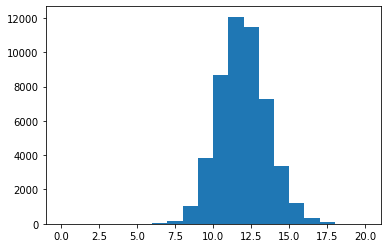

In [ ]:

beyts = [(shah_name[2*i] + ' '+ shah_name[2*i+1]).split() for i in range(len(shah_name)//2)]
length_beyt = np.array([len(beyts[i]) for i in range(len(beyts))])
print('min length:', length_beyt.min(), 'max length:', length_beyt.max())

plt.hist(length_beyt, bins=np.arange(21))
plt.show()


for b in range(len(beyts)):
  for k in range(len(beyts[b])):
    if beyts[b][k] not in stoi.keys():
      beyts[b][k] = 'unk'



In [ ]:
MAX_length = 17 #####################
padded_beyts1 = []
padded_beyts2 = []

for i in range(len(beyts)):
    if length_beyt[i] <= MAX_length:
      
        temp = ['pad'] * (MAX_length - length_beyt[i]+2)
        padded_beyts1.append(temp + beyts[i]) #merge two lists and pad it.
        
        temp = ['pad'] * (MAX_length - length_beyt[i])
        padded_beyts2.append(['sos'] + beyts[i] + ['eos'] + temp) #merge two lists and pad it.



In [ ]:

beyt_num1 = np.zeros((len(padded_beyts1), len(padded_beyts1[0])))
beyt_num2 = np.zeros((len(padded_beyts2), len(padded_beyts2[0])))

for i in tqdm(range(len(padded_beyts1))):
    beyt_num1[i,:] = np.array([stoi[padded_beyts1[i][j]] for j in range(len(padded_beyts1[i]))])

for i in tqdm(range(len(padded_beyts2))):
    beyt_num2[i,:] = np.array([stoi[padded_beyts2[i][j]] for j in range(len(padded_beyts2[i]))])

first_beyt_num = beyt_num1[:-1,:]
second_beyt_num = beyt_num2[1:,:]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

beyt_num1 = torch.tensor(beyt_num1, dtype=torch.long).to(device)
beyt_num2 = torch.tensor(beyt_num2, dtype=torch.long).to(device)

first_beyt_num = torch.tensor(first_beyt_num, dtype=torch.long).to(device)
second_beyt_num = torch.tensor(second_beyt_num, dtype=torch.long).to(device)


  0%|          | 0/49587 [00:00<?, ?it/s]

  0%|          | 0/49587 [00:00<?, ?it/s]

In [ ]:

class MY_Dataset(Dataset):
    def __init__(self, X, Y):
        self.x = X
        self.y = Y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):

        return self.x[idx,:], self.y[idx,:]


n = len(first_beyt_num)
n_train = int(np.floor(n*0.7))
temp = np.arange(n)
np.random.shuffle(temp)

first_shuffled = first_beyt_num[temp,:]
second_shuffled = second_beyt_num[temp,:]

Data_train = MY_Dataset(first_shuffled[:n_train,:], second_shuffled[:n_train,:])
Data_test = MY_Dataset(first_shuffled[n_train:,:], second_shuffled[n_train:,:])

train_dataloader = DataLoader(Data_train, batch_size=128, shuffle=True)
test_dataloader = DataLoader(Data_test, batch_size=512, shuffle=False)

print(f'#train sample: {len(Data_train)}, #test sample: {len(Data_test)}')



#train sample: 34710, #test sample: 14876


In [ ]:
print(Data_train[0])


(tensor([6270, 6270, 6270, 6270, 6270, 6270, 6270, 6270,   13,  156, 2588, 1477,
         322,   17, 2077,  101,    1, 1076, 3025], device='cuda:0'), tensor([6271, 6273,   75,   43,  522, 2397, 1076, 1321,   48,   58,  115, 6272,
        6270, 6270, 6270, 6270, 6270, 6270, 6270], device='cuda:0'))


In [ ]:
# LSTM
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        # self.embedding = nn.Embedding(input_dim, emb_dim)
        self.embedding = nn.Embedding.from_pretrained(EMBEDDINGS)
        self.embedding.weight.requires_grad = False
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src : [sen_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        
        # embedded : [sen_len, batch_size, emb_dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [sen_len, batch_size, hid_dim * n_directions]
        # hidden = [n_layers * n_direction, batch_size, hid_dim]
        # cell = [n_layers * n_direction, batch_size, hid_dim]

        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        # self.embedding = nn.Embedding(output_dim, emb_dim)
        self.embedding = nn.Embedding.from_pretrained(EMBEDDINGS)
        self.embedding.weight.requires_grad = False
        
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=self.n_layers, dropout=dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.softmax = nn.Softmax()
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        # input = [batch_size]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
       
        input = input.unsqueeze(0)
        # input : [1, ,batch_size]
        
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch_size, emb_dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq_len, batch_size, hid_dim * n_dir]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        # seq_len and n_dir will always be 1 in the decoder
#         prediction = self.softmax(self.fc_out(output.squeeze(0)))
        prediction = self.fc_out(output.squeeze(0))
        
        
        # prediction = [batch_size, output_dim]
        
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            'hidden dimensions of encoder and decoder must be equal.'
        assert encoder.n_layers == decoder.n_layers, \
            'n_layers of encoder and decoder must be equal.'
        
    def forward(self, src, trg, teacher_forcing_ratio=0.75):
        # src = [sen_len, batch_size]
        # trg = [sen_len, batch_size]
        # teacher_forcing_ratio : the probability to use the teacher forcing.

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)   
        
        

        # first input to the decoder is the <sos> token.
        input = trg[0, :]

        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states 
            # receive output tensor (predictions) and new hidden and cell states.
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # replace predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not.
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions.
            top1 = output.argmax(1)
            # update input : use ground_truth when teacher_force 
            input = trg[t] if teacher_force else top1
            
        return outputs


In [ ]:
# GRU
class Encoder_GRU(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout, bidirectional=True)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src : [sen_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        
        # embedded : [sen_len, batch_size, emb_dim]
        outputs, state = self.rnn(embedded)
        # outputs = [sen_len, batch_size, hid_dim * n_directions]
        # hidden = [n_layers * n_direction, batch_size, hid_dim]
        # cell = [n_layers * n_direction, batch_size, hid_dim]

        return outputs, state


class Decoder_GRU(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        bidirectional = True
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, hid_dim, num_layers=self.n_layers, dropout=dropout, bidirectional=bidirectional)
        
        self.fc_out = nn.Linear(hid_dim*(1+bidirectional), output_dim)
        self.softmax = nn.Softmax()
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, state):
        
        # input = [batch_size]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        # print(input.shape, hidden.shape, cell.shape)
        input = input.unsqueeze(0)
        # input : [1, ,batch_size]
        
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch_size, emb_dim]
        
        output, state = self.rnn(embedded, state)
        # output = [seq_len, batch_size, hid_dim * n_dir]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        # seq_len and n_dir will always be 1 in the decoder
#         prediction = self.softmax(self.fc_out(output.squeeze(0)))
        prediction = self.fc_out(output.squeeze(0))
    
        # prediction = [batch_size, output_dim]
        return prediction, state


class Seq2Seq_GRU(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            'hidden dimensions of encoder and decoder must be equal.'
        assert encoder.n_layers == decoder.n_layers, \
            'n_layers of encoder and decoder must be equal.'
        
    def forward(self, src, trg, teacher_forcing_ratio=0.75):
        # src = [sen_len, batch_size]
        # trg = [sen_len, batch_size]
        # teacher_forcing_ratio : the probability to use the teacher forcing.

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        enc_output, state = self.encoder(src)
        
        # first input to the decoder is the <sos> token.
        input = trg[0, :]
        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states 
            # receive output tensor (predictions) and new hidden and cell states.
            output, state = self.decoder(input, state)
            
            # replace predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not.
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions.
            top1 = output.argmax(1)
            # update input : use ground_truth when teacher_force 
            input = trg[t] if teacher_force else top1
            
        return outputs


In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    size = 0
    correct = 0

    for i, batch in enumerate(iterator):
        
        src = batch[0].permute(1,0)
        trg = batch[1].permute(1,0)

        optimizer.zero_grad()
        # trg = [sen_len, batch_size]
        # output = [trg_len, batch_size, output_dim]
        output = model(src, trg)
        output_dim = output.shape[-1]
   
        # transfrom our output : slice off the first column, and flatten the output into 2 dim.
        output = output[1:].contiguous().view(-1, output_dim) 
        trg = trg[1:].contiguous().view(-1)
        # trg = [(trg_len-1) * batch_size]
        # output = [(trg_len-1) * batch_size, output_dim]
        
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        correct += (output.argmax(1) == trg).type(torch.float).sum().item()
        size += trg.shape[0]

    correct /= size
    return epoch_loss / len(iterator), correct


def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    size = 0
    correct = 0

    with torch.no_grad():
        
        for i, batch in enumerate(iterator):
            
            src = batch[0]
            trg = batch[1]

            output = model(src, trg, 0) # turn off teacher forcing.
            
            # trg = [sen_len, batch_size]
            # output = [sen_len, batch_size, output_dim]
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            correct += (output.argmax(1) == trg).type(torch.float).sum().item()
            size += trg.shape[0]

    correct /= size
    return epoch_loss / len(iterator), correct


# LSTM

In [ ]:
# First initialize our model.
ENC_EMB_DIM = 100
DEC_EMB_DIM = 100
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)


def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.5, 0.5)
        
model.apply(init_weights)


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6274, 100)
    (rnn): LSTM(100, 256, num_layers=3, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6274, 100)
    (rnn): LSTM(100, 256, num_layers=3, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=6274, bias=True)
    (softmax): Softmax(dim=None)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
a, b = torch.unique(beyt_num2.reshape(-1), return_counts=True)
word_repitition = torch.zeros(len(stoi), device=device)
word_repitition[a] = b.type(torch.float)
weight = 1/word_repitition
# weight = (1/torch.tanh(word_repitition))

weight[weight==torch.inf] = 0


optimizer = torch.optim.Adam(model.parameters(),lr=0.0002, weight_decay=0.1)
criterion = nn.CrossEntropyLoss(ignore_index=stoi['pad']) #, weight=weight

N_EPOCHS = 50

CLIP = 0.01

best_test_loss = float('inf')

# custom_embeddings.stoi['pad'] = 6270
# custom_embeddings.stoi['sos'] = 6271
# custom_embeddings.stoi['eos'] = 6272
# custom_embeddings.stoi['unk'] = 6273


In [ ]:
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, CLIP)
    test_loss, test_acc = evaluate(model, test_dataloader, criterion)
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    # b = 0
    # output = model(first_beyt_num[b:b+1,:].permute(1,0), second_beyt_num[b:b+1,:].permute(1,0), 0).argmax(2).reshape(-1).cpu().numpy()[1:]
    # print(' '.join([itos[output[i]] for i in range(len(output))]))

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'Seq2SeqModel_LSTM.pt')
    print(f"Epoch: {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.3f}, \t train accuracy: {train_acc}")
    print(f"\tTest  Loss: {test_loss:.3f}, \t test  accuracy: {test_acc}")


Epoch: 01
	Train Loss: 9.712, 	 train accuracy: 0.0001536540862383559
	Test  Loss: 9.725, 	 test  accuracy: 0.00016662294291568878
Epoch: 02
	Train Loss: 9.354, 	 train accuracy: 0.00010403662089055348
	Test  Loss: 9.352, 	 test  accuracy: 0.0001595326049192765
Epoch: 03
	Train Loss: 9.116, 	 train accuracy: 0.00012644450846698038
	Test  Loss: 9.060, 	 test  accuracy: 0.000244616660876224
Epoch: 04
	Train Loss: 8.941, 	 train accuracy: 0.00019206760779794487
	Test  Loss: 8.874, 	 test  accuracy: 0.00021980047788878096
Epoch: 05
	Train Loss: 8.825, 	 train accuracy: 0.00025128845353564454
	Test  Loss: 8.762, 	 test  accuracy: 0.0004608719697667988
Epoch: 06
	Train Loss: 8.753, 	 train accuracy: 0.0004817695828931784
	Test  Loss: 8.709, 	 test  accuracy: 0.0009217439395335976
Epoch: 07
	Train Loss: 8.727, 	 train accuracy: 0.0008194884599378981
	Test  Loss: 8.714, 	 test  accuracy: 0.002502889312733538
Epoch: 08
	Train Loss: 8.725, 	 train accuracy: 0.0003745318352059925
	Test  Loss: 8.7

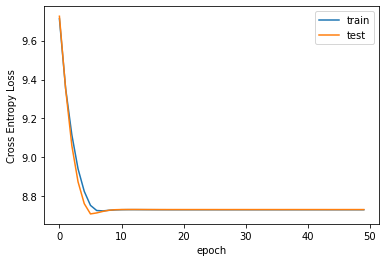

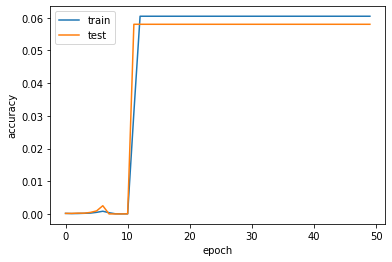

In [ ]:
plt.plot(np.arange(N_EPOCHS), train_loss_list)
plt.plot(np.arange(N_EPOCHS), test_loss_list)
plt.xlabel('epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend(['train', 'test'])
plt.show()

plt.plot(np.arange(N_EPOCHS), train_acc_list)
plt.plot(np.arange(N_EPOCHS), test_acc_list)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()


# GRU

In [ ]:
# First initialize our model.
ENC_EMB_DIM = 100
DEC_EMB_DIM = 100
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

encoder = Encoder_GRU(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder_GRU(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq_GRU(encoder, decoder, device).to(device)


def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.5, 0.5)
        
model.apply(init_weights)


Seq2Seq_GRU(
  (encoder): Encoder_GRU(
    (embedding): Embedding(6274, 100)
    (rnn): GRU(100, 256, num_layers=3, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder_GRU(
    (embedding): Embedding(6274, 100)
    (rnn): GRU(100, 256, num_layers=3, dropout=0.5, bidirectional=True)
    (fc_out): Linear(in_features=512, out_features=6274, bias=True)
    (softmax): Softmax(dim=None)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
a, b = torch.unique(beyt_num2.reshape(-1), return_counts=True)
word_repitition = torch.zeros(len(stoi), device=device)
word_repitition[a] = b.type(torch.float)
weight = 1/word_repitition
weight[weight==torch.inf] = 0

# weight = (1/torch.tanh(word_repitition/10000))

optimizer = torch.optim.Adam(model.parameters(),lr=0.0002, weight_decay=0.1)
criterion = nn.CrossEntropyLoss(ignore_index=stoi['pad']) #, weight=weight

N_EPOCHS = 50

CLIP = 0.01

best_test_loss = float('inf')


In [ ]:
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, CLIP)
    test_loss, test_acc = evaluate(model, test_dataloader, criterion)
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    # b = 0
    # output = model(first_beyt_num[b:b+1,:].permute(1,0), second_beyt_num[b:b+1,:].permute(1,0), 0).argmax(2).reshape(-1).cpu().numpy()[1:]
    # print(' '.join([itos[output[i]] for i in range(len(output))]))
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'Seq2SeqModel_GRU.pt')
    print(f"Epoch: {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.3f}, \t train accuracy: {train_acc}")
    print(f"\tTest  Loss: {test_loss:.3f}, \t test  accuracy: {test_acc}")


Epoch: 01
	Train Loss: 20.120, 	 train accuracy: 0.0001968692979928935
	Test  Loss: 18.209, 	 test  accuracy: 0.00016307777391748264
Epoch: 02
	Train Loss: 16.874, 	 train accuracy: 0.00018726591760299626
	Test  Loss: 15.663, 	 test  accuracy: 0.00013826159093003964
Epoch: 03
	Train Loss: 14.230, 	 train accuracy: 0.000169659720221518
	Test  Loss: 13.814, 	 test  accuracy: 0.00012053574593900891
Epoch: 04
	Train Loss: 12.202, 	 train accuracy: 0.00014565126924677486
	Test  Loss: 12.147, 	 test  accuracy: 4.254202797847373e-05
Epoch: 05
	Train Loss: 10.726, 	 train accuracy: 0.00012644450846698038
	Test  Loss: 10.864, 	 test  accuracy: 1.0635506994618433e-05
Epoch: 06
	Train Loss: 9.711, 	 train accuracy: 9.443324050065624e-05
	Test  Loss: 9.821, 	 test  accuracy: 3.5451689982061445e-06
Epoch: 07
	Train Loss: 9.089, 	 train accuracy: 4.961746534780243e-05
	Test  Loss: 9.151, 	 test  accuracy: 0.0
Epoch: 08
	Train Loss: 8.801, 	 train accuracy: 5.922084573769967e-05
	Test  Loss: 8.787, 	

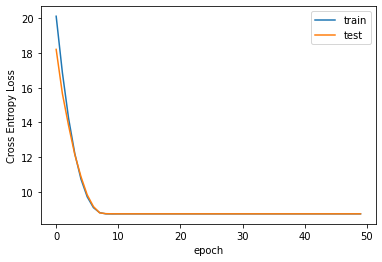

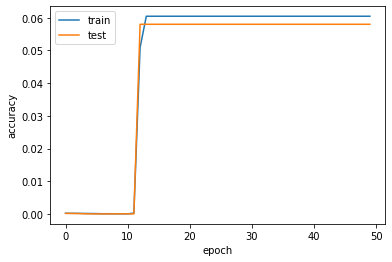

In [ ]:
plt.plot(np.arange(N_EPOCHS), train_loss_list)
plt.plot(np.arange(N_EPOCHS), test_loss_list)
plt.xlabel('epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend(['train', 'test'])
plt.show()

plt.plot(np.arange(N_EPOCHS), train_acc_list)
plt.plot(np.arange(N_EPOCHS), test_acc_list)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()


# test

In [ ]:

def test():
    best_model = Seq2Seq(encoder, decoder, device).to(device)
    best_model.load_state_dict(torch.load('Seq2SeqModel_LSTM.pt'))
    
    test_loss, test_acc = evaluate(model, test_dataloader, criterion)
    
    print(f"Test Loss : {test_loss:.3f}, {test_acc}")
    
test()

Test Loss : 6.941, 0.05270602749633075
